## Goal

E-commerce websites often transact huge amounts of money. And whenever a huge amount of money is moved, there is a high risk of users performing fraudulent activities, e.g. using stolen credit cards, doing money laundry, etc.
Machine Learning really excels at identifying fraudulent activities. Any website where you put your credit card information has a risk team in charge of avoiding frauds via machine learning.

The goal of this challenge is to build a machine learning model that predicts the probability that the first transaction of a new user is fraudulent.

## Challenge Description

Company XYZ is an e-commerce site that sells hand-made clothes.

You have to build a model that predicts whether a user has a high probability of using the site to perform some illegal activity or not. This is a super common task for data scientists.

You only have information about the user first transaction on the site and based on that you have to make your classification ("fraud/no fraud").

These are the tasks you are asked to do:

For each user, determine her country based on the numeric IP address.

Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?

Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

## Data

###  "Fraud_Data":

user_id : Id of the user. Unique by user

signup_time : the time when the user created her account (GMT time)

purchase_time : the time when the user bought the item (GMT time)

purchase_value : the cost of the item purchased (USD)

device_id : the device id. You can assume that it is unique by device. I.e., 2 transactions with the same device ID means that the same physical device was used to buy

source : user marketing channel: ads, SEO, Direct (i.e. came to the site by directly typing the site address on the browser).

browser : the browser used by the user.

sex : user sex: Male/Female

age : user age

ip_address : user numeric ip address

class : this is what we are trying to predict: whether the activity was fraudulent (1) or not (0).


### "IpAddress_to_Country"

lower_bound_ip_address : the lower bound of the numeric ip address for that country 

upper_bound_ip_address : the upper bound of the numeric ip address for that country 

country : the corresponding country. If a user has an ip address whose value is within the upper and lower bound, then she is based in this country.

In [12]:
%matplotlib inline
import random
import pandas as pd
import numpy as np
import scipy.stats as st
from datetime import date, timedelta


import pdpbox
from pdpbox import pdp
from pdpbox.info_plots import target_plot
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
from sklearn.tree.export import export_text
from sklearn.tree import plot_tree
from sklearn import preprocessing

In [116]:
Fraud = pd.read_csv("Fraud_Data.csv",parse_dates=['signup_time','purchase_time'])
Ip = pd.read_csv("IpAddress_to_Country.csv")

In [114]:
Fraud = pd.read_csv("Fraud.csv",parse_dates=['signup_time','purchase_time'])

In [2]:
dt = pd.read_csv("Fraud_comp.csv",parse_dates=['signup_time','purchase_time'])

In [3]:
print(dt.shape)
dt.head()

(151112, 16)


,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval,same_ip_uid,same_did_uid
0,0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,52 days 03:51:22.000000000,1.0,1
1,1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,0 days 04:59:04.000000000,1.0,1
2,2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0 days 00:00:01.000000000,12.0,12
3,3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None,5 days 16:41:25.000000000,1.0,1
4,4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,50 days 11:31:01.000000000,1.0,1


In [16]:
print(Ip.shape)
Ip.head()

(138846, 3)


,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


### Question 1
For each user, determine her country based on the numeric IP address.

In [117]:
country_list = []
for i in range(Fraud.shape[0]):
    country_cell = Ip['country'][(Ip["lower_bound_ip_address"]<Fraud['ip_address'][i]) & (Ip["upper_bound_ip_address"]>Fraud['ip_address'][i])]
    if len(country_cell)>0:
        country_list.append(country_cell.iloc[0])
    else: country_list.append("None")
Fraud['country']=country_list

In [33]:
Ip['country'][(Ip["lower_bound_ip_address"]<Fraud['ip_address'][i]) & (Ip["upper_bound_ip_address"]>Fraud['ip_address'][i])]

Series([], Name: country, dtype: object)

In [35]:
any((Ip["lower_bound_ip_address"]<Fraud['ip_address'][i]) & (Ip["upper_bound_ip_address"]>Fraud['ip_address'][i]))

False

In [118]:
Fraud.to_csv("Fraud.csv")

In [123]:
Fraud_comp.to_csv("Fraud_comp.csv")

### Feature engineering

Possible signals for fraud which can be detected in our dataset are as following:

1. The time interval between signup_time and purchase_time tend to be different.
2. There are multiple userid linked to the same deviceid or ip address.
3. There are multiple ip address/deviceid for one userid.
4. When a user's ip suddenly change to a different country.
5. The ip_address is not in any country

After check how many levels these variables have, I created the following features:

1. interval
2. same_ip_uid
3. same_did_uid

In [119]:
Fraud['interval'] = Fraud['purchase_time'] - Fraud['signup_time']

In [91]:
# one ip_address, multiple user_id's
mul_ip_uid = pd.DataFrame(Fraud.groupby('ip_address')['user_id'].count())
mul_ip_uid.columns = ['same_ip_uid']
mul_ip_uid['ip_address'] = mul_ip_uid.index
print(all(mul_ip_uid['same_ip_uid']==1))

# one device_id, multiple user_id's
mul_did_uid = pd.DataFrame(Fraud.groupby('device_id')['user_id'].count())
mul_did_uid.columns = ['same_did_uid']
mul_did_uid['device_id'] = mul_did_uid.index
print(all(mul_did_uid['same_did_uid']==1))

# one user_id, multiple device_id's
mul_uid_did = pd.DataFrame(Fraud.groupby('user_id')['device_id'].count())
mul_uid_did.columns = ['same_uid_did']
mul_uid_did['user_id'] = mul_uid_did.index
print(all(mul_uid_did['same_uid_did']==1))

# one user_id, multiple ip_address's
mul_uid_ip = pd.DataFrame(Fraud.groupby('user_id')['ip_address'].count())
mul_uid_ip.columns = ['same_uid_ip']
mul_uid_ip['user_id'] = mul_uid_ip.index
print(all(mul_uid_ip['same_uid_ip']==1))

# one user_if, multiple coutry's
mul_uid_cty = pd.DataFrame(Fraud.groupby('user_id')['country'].count())
mul_uid_cty.columns = ['same_uid_cty']
mul_uid_cty['user_id'] = mul_uid_cty.index
print(all(mul_uid_cty['same_uid_cty']==1))

False
False
True
True
True


So, we know that there are multiple user_id's sharing the same ip_address or device_id. But for each user_id, they only have only one value in ip_address, device_id, country.

In [233]:
dt = Fraud.join(mul_ip_uid.set_index('ip_address'), on='ip_address')
dt = dt.join(mul_did_uid.set_index('device_id'), on='device_id')

In [193]:
dt.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval,same_ip_uid,same_did_uid
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,52 days 03:51:22,1.0,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,0 days 04:59:04,1.0,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,0 days 00:00:01,12.0,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,None,5 days 16:41:25,1.0,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,50 days 11:31:01,1.0,1


### Variable Selection

I will use the following methods to select variables:
1. Univariate analysis
2. Feature importance using Decision tree
3. Correlation Matrix with Heatmap
4. Linear discriminant analysis


#### Univariate analysis

In [15]:
dt['signup_time'] = dt['signup_time'].astype(int)/ 10**15
dt['purchase_time'] = dt['purchase_time'].astype(int)/ 10**15
dt['interval'] = (dt['purchase_time'] - dt['signup_time'])/10**15

In [189]:
def mean_count(dt,group_var,target_var):
    mean = pd.DataFrame(dt.groupby(group_var)[target_var].mean()).reset_index()
    mean.columns = [group_var,'mean']
    count = pd.DataFrame(dt.groupby(group_var)[target_var].count()).reset_index()
    count.columns = [group_var,'count']
    mc = pd.merge(left=mean,right=count, left_on=group_var, right_on=group_var)
    return mc

In [206]:
def mc_plot(df,groupvar):
    fig, ax = plt.subplots(figsize=(16,4))
    sns.lineplot(x=df[groupvar], 
                 y=df['mean'],
                 color='r',
                 ax=ax)
    sns.lineplot(x=df[groupvar], 
                 y=df['count'], 
                 color='b',
                 ax=ax)    
    ax.legend(['mean', 'count'], facecolor='w')
    plt.show()

(<Figure size 1080x648 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a496a4d30>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a48aefda0>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a48ab85c0>},
    x      display_column  value_lower  value_upper percentile_column  \
 0  0  [1420.07, 1421.34)  1420.070442  1421.342559        [0, 11.11)   
 1  1  [1421.34, 1423.67)  1421.342559  1423.665713    [11.11, 22.22)   
 2  2  [1423.67, 1425.97)  1423.665713  1425.971063    [22.22, 33.33)   
 3  3  [1425.97, 1428.27)  1425.971063  1428.269204    [33.33, 44.44)   
 4  4  [1428.27, 1430.57)  1428.269204  1430.570136    [44.44, 55.56)   
 5  5   [1430.57, 1432.9)  1430.570136  1432.901696    [55.56, 66.67)   
 6  6   [1432.9, 1435.23)  1432.901696  1435.229432    [66.67, 77.78)   
 7  7  [1435.23, 1437.55)  1435.229432  1437.548520    [77.78, 88.89)   
 8  8  [1437.55, 1439.87]  1437.548520  1439.872829      [88.89, 100]   
 
    percentile_lower

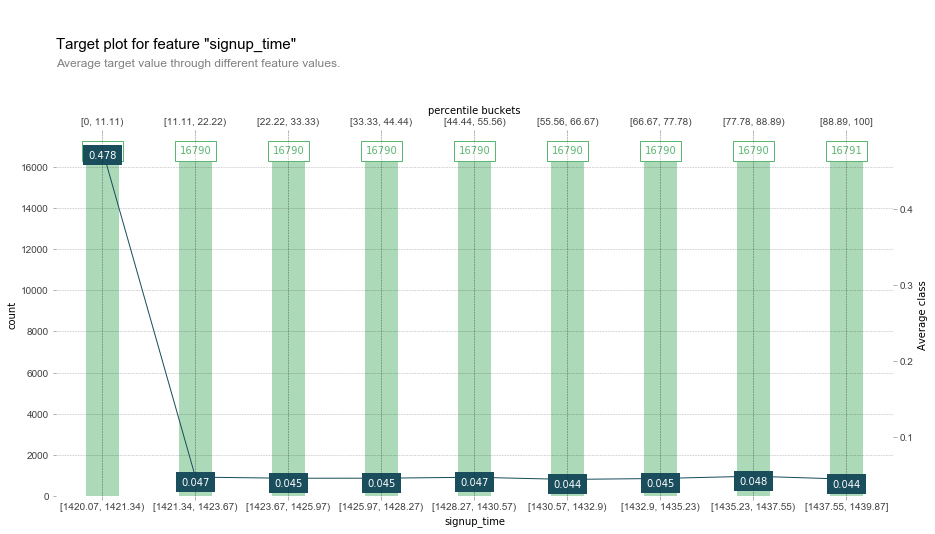

In [226]:
target_plot(
    df=dt, feature='signup_time', feature_name='signup_time', target='class', show_percentile=True)

(<Figure size 1080x648 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a46670048>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a41798c50>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a2325ca20>},
    x      display_column  value_lower  value_upper percentile_column  \
 0  0  [1420.07, 1425.23)  1420.070444  1425.234306        [0, 11.11)   
 1  1  [1425.23, 1428.71)  1425.234306  1428.707165    [11.11, 22.22)   
 2  2  [1428.71, 1431.15)  1428.707165  1431.151862    [22.22, 33.33)   
 3  3  [1431.15, 1433.48)  1431.151862  1433.480223    [33.33, 44.44)   
 4  4  [1433.48, 1435.78)  1433.480223  1435.777971    [44.44, 55.56)   
 5  5  [1435.78, 1438.08)  1435.777971  1438.083968    [55.56, 66.67)   
 6  6  [1438.08, 1440.44)  1438.083968  1440.435919    [66.67, 77.78)   
 7  7   [1440.44, 1443.3)  1440.435919  1443.295031    [77.78, 88.89)   
 8  8   [1443.3, 1450.23]  1443.295031  1450.234565      [88.89, 100]   
 
    percentile_lower

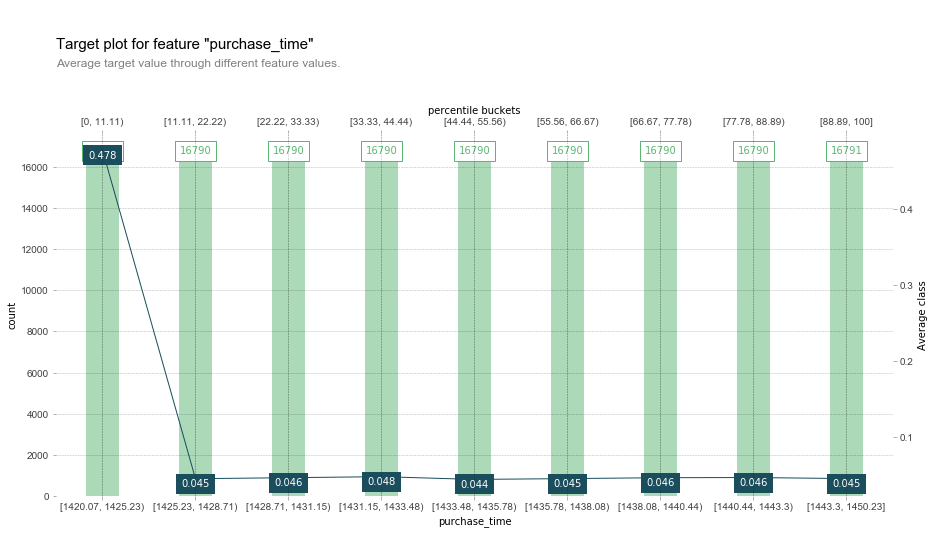

In [227]:
target_plot(
    df=dt, feature='purchase_time', feature_name='purchase_time', target='class', show_percentile=True)

(<Figure size 1080x648 with 4 Axes>,
 {'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a48a25080>,
  'bar_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a4c631dd8>,
  'line_ax': <matplotlib.axes._subplots.AxesSubplot at 0x1a4e9e03c8>},
    x display_column  value_lower  value_upper percentile_column  \
 0  0    [0.0, 0.67)     0.000001     0.673376        [0, 11.11)   
 1  1    [0.67, 1.9)     0.673376     1.897027    [11.11, 22.22)   
 2  2     [1.9, 3.1)     1.897027     3.096647    [22.22, 33.33)   
 3  3    [3.1, 4.32)     3.096647     4.319729    [33.33, 44.44)   
 4  4   [4.32, 5.53)     4.319729     5.525430    [44.44, 55.56)   
 5  5   [5.53, 6.74)     5.525430     6.738382    [55.56, 66.67)   
 6  6   [6.74, 7.95)     6.738382     7.947307    [66.67, 77.78)   
 7  7   [7.95, 9.15)     7.947307     9.154311    [77.78, 88.89)   
 8  8  [9.15, 10.37]     9.154311    10.367972      [88.89, 100]   
 
    percentile_lower  percentile_upper  count     class  
 0          

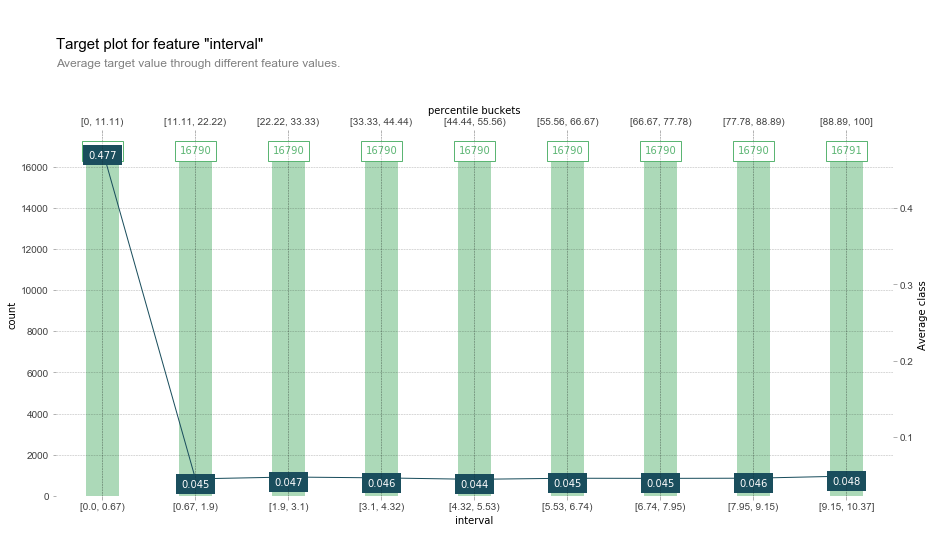

In [228]:
target_plot(
    df=dt, feature='interval', feature_name='interval', target='class', show_percentile=True)

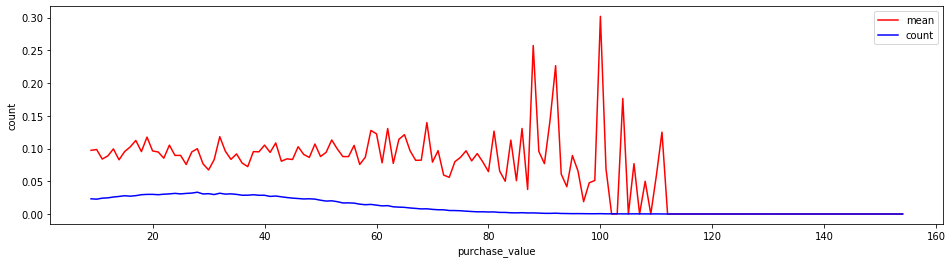

In [215]:
pv_mc = mean_count(dt,group_var='purchase_value',target_var='class')
pv_mc['count'] = pv_mc['count'] /10**5
mc_plot(pv_mc,groupvar = 'purchase_value')

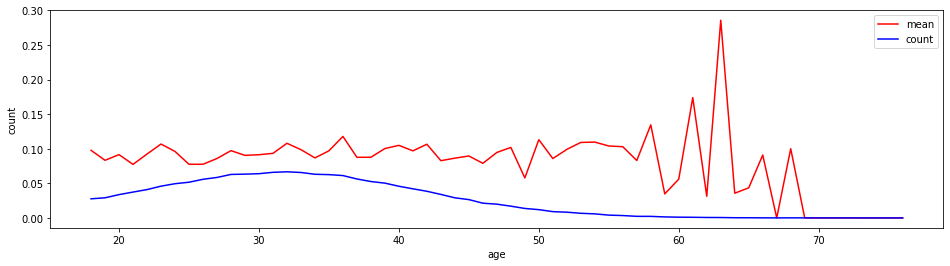

In [214]:
age_mc = mean_count(dt,group_var='age',target_var='class')
age_mc['count'] = age_mc['count'] /10**5
mc_plot(age_mc,groupvar = 'age')

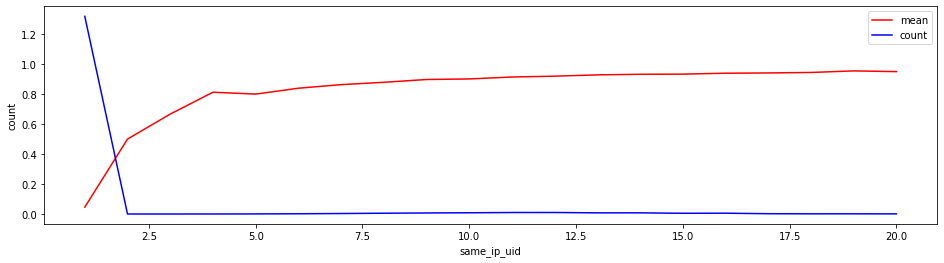

In [212]:
same_ip_uid_mc = mean_count(dt,group_var='same_ip_uid',target_var='class')
same_ip_uid_mc['count'] = same_ip_uid_mc['count'] /10**5

mc_plot(same_ip_uid_mc,groupvar = 'same_ip_uid')

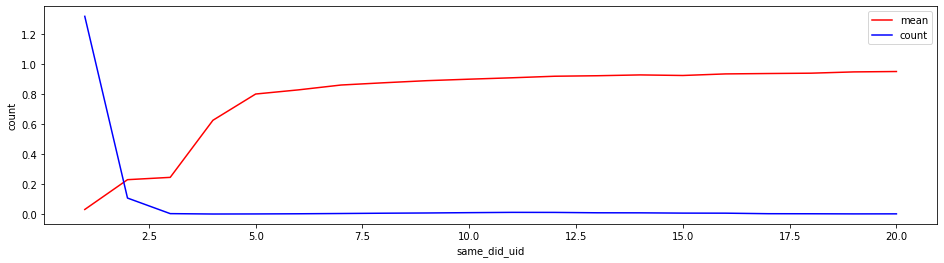

In [211]:
sdu_mc = mean_count(dt,group_var='same_did_uid',target_var='class')
sdu_mc['count'] = sdu_mc['count'] /10**5
mc_plot(sdu_mc,groupvar = 'same_did_uid')

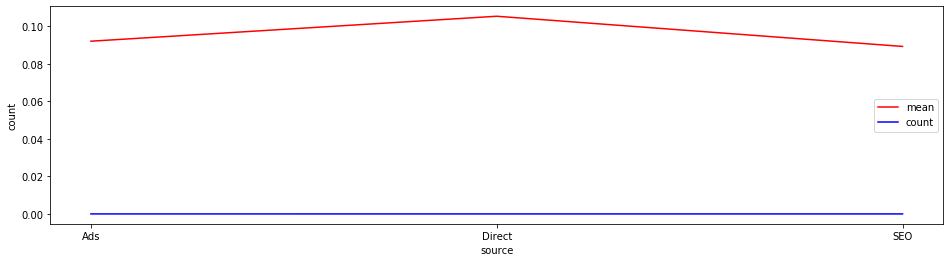

In [210]:
source_mc = mean_count(dt,group_var='source',target_var='class')
source_mc['count'] = browser_mc['count'] /10**5
mc_plot(source_mc,groupvar = 'source')

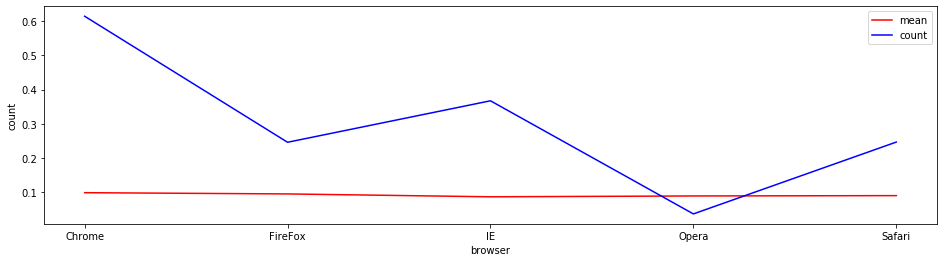

In [207]:
browser_mc = mean_count(dt,group_var='browser',target_var='class')
browser_mc['count'] = browser_mc['count'] /10**5
mc_plot(browser_mc,groupvar = 'browser')

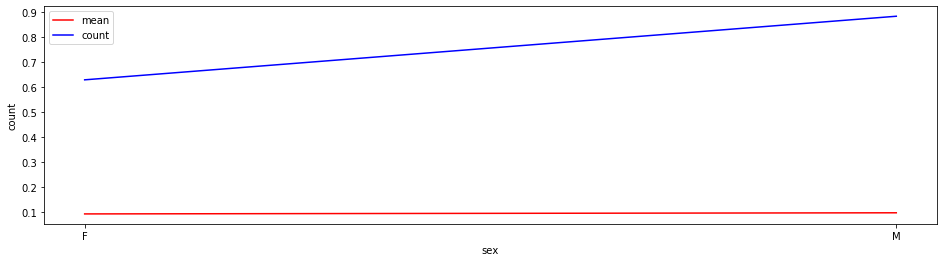

In [208]:
sex_mc = mean_count(dt,group_var='sex',target_var='class')
sex_mc['count'] = sex_mc['count'] /10**5
mc_plot(sex_mc,groupvar = 'sex')

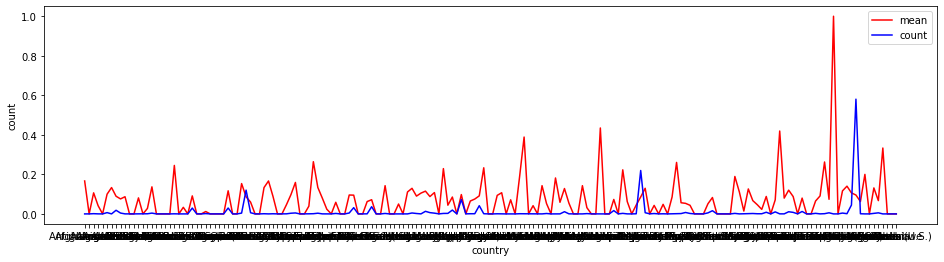

In [209]:
country_mc = mean_count(dt,group_var='country',target_var='class')
country_mc['count'] = country_mc['count'] /10**5
mc_plot(country_mc,groupvar = 'country')

#### Feature importance using Decision tree

In [10]:
dt = pd.get_dummies(dt, prefix_sep="_",columns=['source','browser','sex','country'])

In [19]:
dt1 = dt.drop(columns=['Unnamed: 0','user_id','device_id'])

In [21]:
X=dt1.loc[:, dt1.columns != 'class']
Y=dt1['class']
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1) 

In [23]:
clf_gini = DecisionTreeClassifier(criterion = "gini", 
            random_state = 1,max_depth=3, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)
y_pred = clf_gini.predict(X_test) 
confusion_matrix(y_test, y_pred)

In [ ]:
accuracy_score(y_test,y_pred)*100

In [ ]:
f_imp = pd.DataFrame(clf_gini.feature_importances_)
f_imp.columns = ['importance']
f_imp['feature'] = feature_name
f_imp[f_imp['importance']>0]

In [18]:
dt.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,age,ip_address,class,interval,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,0,22058,1424.818549,1429.325231,34,QVPSPJUOCKZAR,39,7.327584e+08,0,4.506682e-15,...,0,0,0,0,0,0,0,0,0,0
1,1,333320,1433.709590,1433.727534,16,EOGFQPIZPYXFZ,53,3.503114e+08,0,1.794400e-17,...,1,0,0,0,0,0,0,0,0,0
2,2,1359,1420.138364,1420.138365,15,YSSKYOSJHPPLJ,53,2.621474e+09,1,1.000000e-21,...,1,0,0,0,0,0,0,0,0,0
3,3,150084,1430.255605,1430.747690,44,ATGTXKYKUDUQN,41,3.840542e+09,0,4.920850e-16,...,0,0,0,0,0,0,0,0,0,0
4,4,221365,1437.462592,1441.824053,39,NAUITBZFJKHWW,45,4.155831e+08,0,4.361461e-15,...,1,0,0,0,0,0,0,0,0,0


### Domain knowledge
The possible goal for data analysis in this area
1. Unify authentication methods and better (and more consistent) log in experience. 
2. anomaly detection
3. real-time authentication decisions.


Authentication factors fall into several categories: 
1. Knowledge Factors (something the user knows): The requesting party demonstrates that it has knowledge of some unique data associated with the party whose identity is being authenticated, such as a password, security questions, or a PIN. 
2. Ownership Factors (something the user has): The requesting party demonstrates that it has possession of something uniquely associated with the party whose identity is being authenticated, such as a security token, email account, ID card, or a mobile device (in the case of a mobile device, ownership can be confirmed by sending a one-time password to the device that has been pre-registered with the organization). 
3. Inherence Factors (something the user is or does): The requesting party demonstrates that it has a feature inherent to the party whose identity is being authenticated, such as a matching fingerprint, iris pattern, or facial features (these techniques are commonly referred to as “biometrics”).